# Machine Learning Foundation

## Course 5, Part e: CNN DEMO

## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

#In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
# Dropout -- regularization
# Flatten layer -- when moving from convolutional layers to dense layers 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# Conv -- defines how to move around tensor
# Pooling -- max/mean - reduces shape of tensor
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from keras.datasets import cifar10
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.keras.applications.efficientnet import *

In [3]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape

(32, 32, 3)

[9]


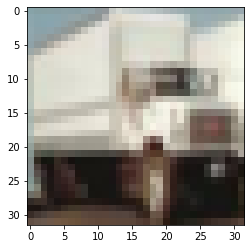

In [5]:
## Let's look at one of the images

print(y_train[444])
plt.imshow(x_train[444]);

In [6]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [8]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [9]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

We still have 181K parameters, even though this is a "small" model.


In [10]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/30
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9123 - accuracy: 0.2929 - val_loss: 1.4595 - val_accuracy: 0.4645
Epoch 2/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.4906 - accuracy: 0.4611 - val_loss: 1.3357 - val_accuracy: 0.5175
Epoch 3/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3744 - accuracy: 0.5062 - val_loss: 1.2164 - val_accuracy: 0.5677
Epoch 4/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3025 - accuracy: 0.5387 - val_loss: 1.2070 - val_accuracy: 0.5769
Epoch 5/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2507 - accuracy: 0.5575 - val_loss: 1.1727 - val_accuracy: 0.5875
Epoch 6/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2068 - accuracy: 0.5762 - val_loss: 1.1176 - val_accuracy: 0.6092
Epoch 7/30
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1843 - accuracy: 0.5847 - val_loss: 1.1313 - val_ac

In [18]:
#model_1.predict_classes(x_test)
model_1.predict(x_test)

array([[8.9528086e-03, 5.6337316e-02, 1.4437743e-02, ..., 1.2548126e-03,
        2.3271401e-01, 2.6679404e-02],
       [1.3748572e-03, 2.6689680e-02, 1.3751502e-19, ..., 5.5479961e-28,
        9.7193199e-01, 3.4395889e-06],
       [2.7397504e-01, 4.6059329e-02, 1.2468722e-03, ..., 1.2613263e-04,
        6.1897582e-01, 5.9008781e-02],
       ...,
       [2.1723828e-05, 4.3223199e-08, 2.2604674e-02, ..., 1.2575452e-01,
        1.8207586e-06, 2.1153101e-06],
       [3.9580026e-01, 7.2338417e-02, 6.3563831e-02, ..., 2.6531953e-01,
        2.3809832e-04, 1.4708329e-02],
       [5.4875441e-06, 4.6035172e-08, 1.3568862e-04, ..., 8.1947201e-01,
        9.3649610e-10, 2.3995892e-07]], dtype=float32)

In [19]:
import numpy as np
np.argmax(y_test,axis=1)

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_test, axis=1), model_1.predict_classes(x_test))

C:\Users\KonuTech\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.5803

### Exercise
Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. Build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

- Use strides of 1 for all convolutional layers.

2. How many parameters does your model have?  How does that compare to the previous model?

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers (on both the training and validation sets)?

5. Try different structures and run times, and see how accurate your model can be.


In [11]:
# Let's build a CNN using Keras' Sequential capabilities

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [12]:
## Check number of parameters

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)       

In [13]:
# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(lr=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [14]:
model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/30
1563/1563 [==============================] - 90s 57ms/step - loss: 1.8065 - accuracy: 0.3352 - val_loss: 1.2646 - val_accuracy: 0.5497
Epoch 2/30
1563/1563 [==============================] - 89s 57ms/step - loss: 1.2363 - accuracy: 0.5627 - val_loss: 1.0767 - val_accuracy: 0.6119
Epoch 3/30
1563/1563 [==============================] - 88s 56ms/step - loss: 1.0500 - accuracy: 0.6320 - val_loss: 1.0300 - val_accuracy: 0.6560
Epoch 4/30
1563/1563 [==============================] - 91s 58ms/step - loss: 0.9512 - accuracy: 0.6703 - val_loss: 0.8188 - val_accuracy: 0.7182
Epoch 5/30
1563/1563 [==============================] - 90s 57ms/step - loss: 0.8801 - accuracy: 0.6999 - val_loss: 0.7967 - val_accuracy: 0.7285
Epoch 6/30
1563/1563 [==============================] - 89s 57ms/step - loss: 0.8442 - accuracy: 0.7127 - val_loss: 0.7504 - val_accuracy: 0.7408
Epoch 7/30
1563/1563 [==============================] - 88s 56ms/step - loss: 0.8214 - accuracy: 0.7211 - val_loss: 0.8118 -

In [21]:
#model_2.predict_classes(x_test)
model_2.predict(x_test)

array([[5.45028970e-02, 2.15618126e-02, 1.71754584e-01, ...,
        3.33862901e-02, 1.62941843e-01, 7.27808401e-02],
       [3.16318870e-02, 3.19279283e-02, 1.18627768e-05, ...,
        2.49525423e-09, 9.32167292e-01, 4.26053023e-03],
       [9.69313979e-02, 4.32164110e-02, 6.12046523e-03, ...,
        7.16109862e-05, 8.26228619e-01, 2.66263336e-02],
       ...,
       [5.59598487e-03, 6.24007589e-05, 3.71869326e-01, ...,
        7.51192048e-02, 4.10276931e-04, 3.67135595e-04],
       [7.25430697e-02, 6.29263371e-02, 2.14962006e-01, ...,
        3.66952084e-03, 1.07033895e-02, 6.95805671e-03],
       [7.30960528e-06, 1.02822939e-09, 2.75166100e-03, ...,
        9.36521351e-01, 1.55345525e-09, 2.78202883e-09]], dtype=float32)

In [22]:
np.argmax(y_test,axis=1)

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [24]:
accuracy_score(np.argmax(y_test, axis=1), model_2.predict_classes(x_test))

0.6171

---
### Machine Learning Foundation (C) 2020 IBM Corporation